In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# ignore possible warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('datasets/survey_results_public.csv')

In [4]:
df.head()

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,...,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,None of these,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,"Employed, full-time",Fully remote,Hobby;Contribute to open-source projects,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Difficult,NaN
2,3,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Friend or family member...,Technical documentation;Blogs;Programming Game...,NaN,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Neither easy nor difficult,40205.0
3,4,I am a developer by profession,"Employed, full-time",Fully remote,I don’t code outside of work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Books / Physical media;School (i.e., Universit...",NaN,NaN,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,215232.0
4,5,I am a developer by profession,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Stack Overflow;O...,NaN,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN


In [5]:
df.shape

(73268, 79)

In [6]:
# df = df[['Country','EdLevel','YearsCode','Employment','RemoteWork','ConvertedCompYearly']]
df = df[['Country','EdLevel','YearsCode','Employment','ConvertedCompYearly']]
df = df.rename({"ConvertedCompYearly" : "Salary"}, axis = 1)

In [7]:
df

,Country,EdLevel,YearsCode,Employment,Salary
0,NaN,NaN,NaN,NaN,NaN
1,Canada,NaN,NaN,"Employed, full-time",NaN
2,United Kingdom of Great Britain and Northern I...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",14,"Employed, full-time",40205.0
3,Israel,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,"Employed, full-time",215232.0
4,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,"Employed, full-time",NaN
...,...,...,...,...,...
73263,Nigeria,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,"Employed, full-time",NaN
73264,United States of America,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6,"Employed, full-time",NaN
73265,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",42,"Employed, full-time",NaN
73266,United Kingdom of Great Britain and Northern I...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",50,"Employed, full-time",NaN


In [8]:
# null counts in each column
df.isnull().sum()

Country        1497
EdLevel        1697
YearsCode      1937
Employment     1559
Salary        35197
dtype: int64

In [9]:
#drop based on NaN salary                                  # NO NEED
# df = df[df['Salary'].notnull()]

In [10]:
# df

In [11]:
#drop anywhere NaN
df.dropna(inplace=True)

In [12]:
df

,Country,EdLevel,YearsCode,Employment,Salary
2,United Kingdom of Great Britain and Northern I...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",14,"Employed, full-time",40205.0
3,Israel,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,"Employed, full-time",215232.0
8,Netherlands,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6,"Employed, full-time",49056.0
10,United Kingdom of Great Britain and Northern I...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,"Employed, full-time",60307.0
11,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",12,"Employed, full-time;Independent contractor, fr...",194400.0
...,...,...,...,...,...
73116,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",21,"Employed, full-time",115000.0
73118,Nigeria,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,"Employed, full-time",57720.0
73119,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,"Employed, full-time",70000.0
73120,Spain,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,"Employed, full-time",35192.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37983 entries, 2 to 73121
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     37983 non-null  object 
 1   EdLevel     37983 non-null  object 
 2   YearsCode   37983 non-null  object 
 3   Employment  37983 non-null  object 
 4   Salary      37983 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.7+ MB


In [14]:
df.isnull().sum()

Country       0
EdLevel       0
YearsCode     0
Employment    0
Salary        0
dtype: int64

In [15]:
df['Employment'].unique()

array(['Employed, full-time',
       'Employed, full-time;Independent contractor, freelancer, or self-employed',
       'Independent contractor, freelancer, or self-employed',
       'Employed, part-time',
       'Independent contractor, freelancer, or self-employed;Employed, part-time',
       'Employed, full-time;Independent contractor, freelancer, or self-employed;Employed, part-time',
       'Employed, full-time;Employed, part-time', 'I prefer not to say',
       'Independent contractor, freelancer, or self-employed;Retired',
       'Retired', 'Employed, part-time;Retired',
       'Employed, full-time;Retired',
       'Employed, full-time;Independent contractor, freelancer, or self-employed;Retired'],
      dtype=object)

In [16]:
df = df[df['Employment'] == 'Employed, full-time']

In [17]:
df

,Country,EdLevel,YearsCode,Employment,Salary
2,United Kingdom of Great Britain and Northern I...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",14,"Employed, full-time",40205.0
3,Israel,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,"Employed, full-time",215232.0
8,Netherlands,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6,"Employed, full-time",49056.0
10,United Kingdom of Great Britain and Northern I...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,"Employed, full-time",60307.0
12,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",12,"Employed, full-time",65000.0
...,...,...,...,...,...
73116,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",21,"Employed, full-time",115000.0
73118,Nigeria,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,"Employed, full-time",57720.0
73119,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,"Employed, full-time",70000.0
73120,Spain,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,"Employed, full-time",35192.0


In [18]:
# drop column Employment for further process
df = df.drop('Employment', axis = 1)

In [19]:
df

,Country,EdLevel,YearsCode,Salary
2,United Kingdom of Great Britain and Northern I...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",14,40205.0
3,Israel,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,215232.0
8,Netherlands,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6,49056.0
10,United Kingdom of Great Britain and Northern I...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,60307.0
12,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",12,65000.0
...,...,...,...,...
73116,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",21,115000.0
73118,Nigeria,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,57720.0
73119,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,70000.0
73120,Spain,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,35192.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31433 entries, 2 to 73121
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Country    31433 non-null  object 
 1   EdLevel    31433 non-null  object 
 2   YearsCode  31433 non-null  object 
 3   Salary     31433 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [21]:
df['Country'].value_counts()

United States of America                                7867
Germany                                                 2388
United Kingdom of Great Britain and Northern Ireland    2344
India                                                   1877
Canada                                                  1251
                                                        ... 
Haiti                                                      1
Zambia                                                     1
Suriname                                                   1
Somalia                                                    1
Seychelles                                                 1
Name: Country, Length: 155, dtype: int64

In [22]:
#functin to remove the countries with low values as may cause problem in algorithmn 
def shorten_categories(categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'other'
    return categorical_map

In [23]:
country_map = shorten_categories(df.Country.value_counts(), 300)
df['Country'] = df['Country'].map(country_map)
df.Country.value_counts()

United States of America                                7867
other                                                   7641
Germany                                                 2388
United Kingdom of Great Britain and Northern Ireland    2344
India                                                   1877
Canada                                                  1251
France                                                  1128
Brazil                                                  1015
Spain                                                    858
Netherlands                                              702
Australia                                                702
Italy                                                    668
Poland                                                   574
Sweden                                                   560
Russian Federation                                       424
Switzerland                                              416
Turkey                  

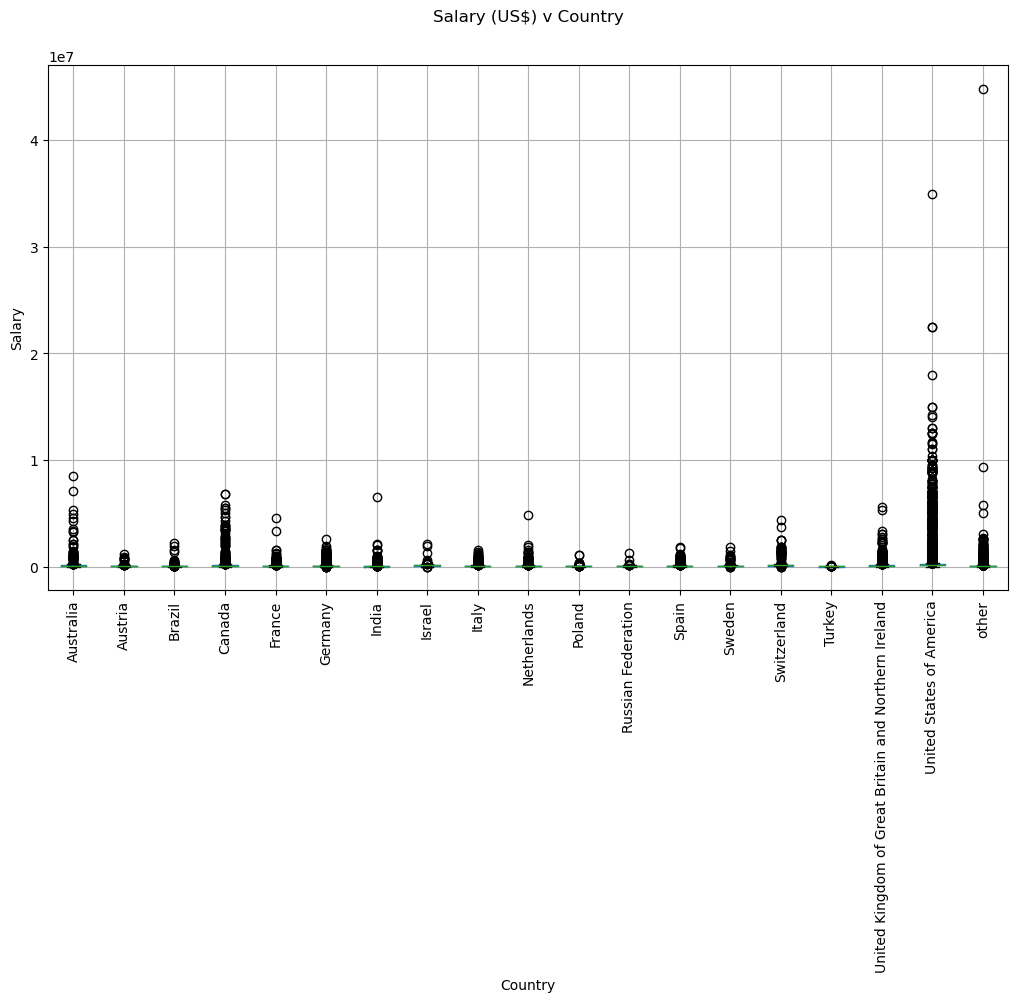

In [24]:
fig, ax = plt.subplots(1,1, figsize = (12,7))
df.boxplot('Salary', 'Country', ax = ax)
plt.suptitle('Salary (US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation = 90)
plt.show()

In [25]:
df = df[df['Salary'] <= 150000]
df = df[df['Salary'] >= 10000]
df = df[df['Country'] != 'Other']

In [26]:
df

,Country,EdLevel,YearsCode,Salary
2,United Kingdom of Great Britain and Northern I...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",14,40205.0
8,Netherlands,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6,49056.0
10,United Kingdom of Great Britain and Northern I...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,60307.0
12,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",12,65000.0
16,other,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,19224.0
...,...,...,...,...
73116,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",21,115000.0
73118,other,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,57720.0
73119,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,70000.0
73120,Spain,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,35192.0


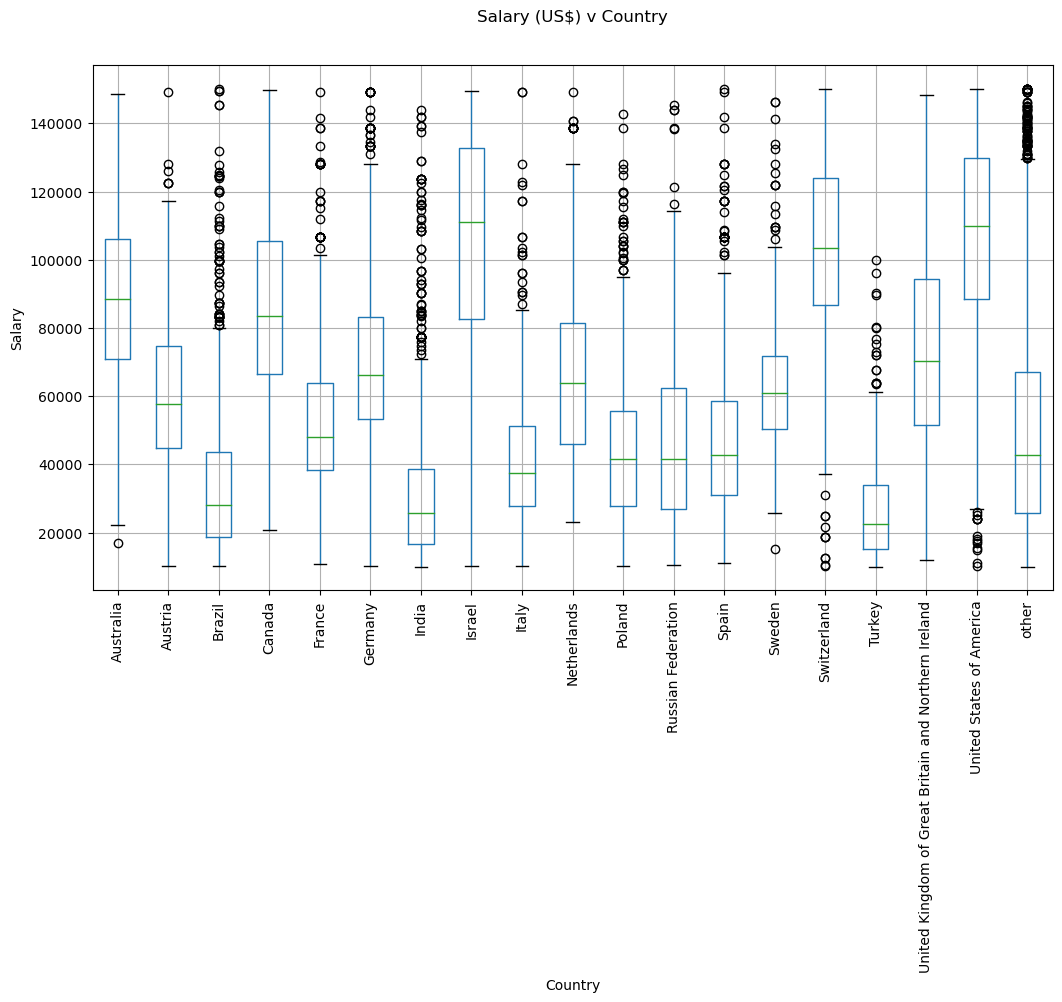

In [27]:
fig, ax = plt.subplots(1,1, figsize = (12,7))
df.boxplot('Salary', 'Country', ax = ax)
plt.suptitle('Salary (US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation = 90)
plt.show()

In [28]:
df['YearsCode'].unique()

array(['14', '6', '5', '12', '7', '36', '25', '16', '10', '20', '24', '3',
       '40', '9', '8', '4', '17', '18', '29', '13', '30', '11', '32',
       '15', '26', '28', '19', '43', '48', '38', '21', '22', '27',
       'Less than 1 year', '37', '23', '35', '39', '1', '2', '34', '46',
       '33', '41', '31', '42', '45', 'More than 50 years', '44', '47',
       '50', '49'], dtype=object)

In [29]:
# function to clean the years code (1 will be 0.5 and >50 will be 50)
def clean_experience(x):
    if x == 'More than 50 years':
        return 50
    if x == 'Less than 1 year':
        return 0.5
    
    return float(x)

df['YearsCode'] = df['YearsCode'].apply(clean_experience)

In [30]:
df['YearsCode'].unique()

array([14. ,  6. ,  5. , 12. ,  7. , 36. , 25. , 16. , 10. , 20. , 24. ,
        3. , 40. ,  9. ,  8. ,  4. , 17. , 18. , 29. , 13. , 30. , 11. ,
       32. , 15. , 26. , 28. , 19. , 43. , 48. , 38. , 21. , 22. , 27. ,
        0.5, 37. , 23. , 35. , 39. ,  1. ,  2. , 34. , 46. , 33. , 41. ,
       31. , 42. , 45. , 50. , 44. , 47. , 49. ])

In [31]:
df['EdLevel'].unique()

array(['Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Something else', 'Associate degree (A.A., A.S., etc.)',
       'Some college/university study without earning a degree',
       'Professional degree (JD, MD, etc.)',
       'Other doctoral degree (Ph.D., Ed.D., etc.)',
       'Primary/elementary school'], dtype=object)

In [32]:
# function to clean the education level
def clean_education(x):
    if 'Master’s degree' in x:
        return 'Master’s degree'
    if 'Bachelor’s degree' in x:
        return 'Bachelor’s degree'
    if 'Professional degree' in x or 'Other doctoral' in x:
        return 'Post grad'
    return 'Less than Bachelors'

df['EdLevel'] = df['EdLevel'].apply(clean_education)

In [33]:
df['EdLevel'].unique()

array(['Master’s degree', 'Bachelor’s degree', 'Less than Bachelors',
       'Post grad'], dtype=object)

## making unique values for education and country (to create a int)

In [34]:
from sklearn.preprocessing import LabelEncoder

In [35]:
le_education = LabelEncoder()
df['EdLevel'] = le_education.fit_transform(df['EdLevel'])
df['EdLevel'].unique()

array([2, 0, 1, 3])

In [36]:
le_country = LabelEncoder()
df['Country'] = le_country.fit_transform(df['Country'])
df['Country'].unique()

array([16,  9, 17, 18,  1,  8,  3,  5,  7, 10,  4,  2, 13, 12, 15,  6,  0,
       14, 11])

In [37]:
df

,Country,EdLevel,YearsCode,Salary
2,16,2,14.0,40205.0
8,9,2,6.0,49056.0
10,16,0,5.0,60307.0
12,17,0,12.0,65000.0
16,18,0,7.0,19224.0
...,...,...,...,...
73116,17,0,21.0,115000.0
73118,18,0,4.0,57720.0
73119,17,0,5.0,70000.0
73120,12,0,6.0,35192.0


# train the model

In [38]:
y = df['Salary']
X = df.drop('Salary', axis = 1)

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
linear_reg = LinearRegression()
linear_reg.fit(X, y.values)

LinearRegression()

In [41]:
y_pred = linear_reg.predict(X)

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [43]:
error = np.sqrt(mean_squared_error(y,y_pred))

In [44]:
error

34403.93345635588

### Second model

In [45]:
from sklearn.tree import DecisionTreeRegressor

In [46]:
dec_tree_reg = DecisionTreeRegressor(random_state = 0)
dec_tree_reg.fit(X,y.values)

DecisionTreeRegressor(random_state=0)

In [47]:
y_pred = dec_tree_reg.predict(X)

In [48]:
error = np.sqrt(mean_squared_error(y,y_pred))
print("${:,.02f}".format(error))

$23,303.78


## third model

In [49]:
from sklearn.ensemble import RandomForestRegressor

In [50]:
random_forest_reg = RandomForestRegressor(random_state = 0)
random_forest_reg.fit(X,y.values)

RandomForestRegressor(random_state=0)

In [51]:
y_pred = random_forest_reg.predict(X)

In [52]:
error = np.sqrt(mean_squared_error(y,y_pred))
print("${:,.02f}".format(error))

$23,361.17


## forth model

In [53]:
from sklearn.model_selection import GridSearchCV

In [54]:
max_depth = [None, 2, 4, 6, 8, 10, 12]
parameters = {"max_depth" : max_depth}

regressor = DecisionTreeRegressor(random_state = 0)
gs = GridSearchCV(regressor, parameters, scoring = 'neg_mean_squared_error')
gs.fit(X, y.values)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [None, 2, 4, 6, 8, 10, 12]},
             scoring='neg_mean_squared_error')

In [55]:
regressor = gs.best_estimator_

regressor.fit(X, y.values)
y_pred = regressor.predict(X)
error = np.sqrt(mean_squared_error(y,y_pred))
print("${:,.02f}".format(error))

$24,382.61


In [56]:
X

,Country,EdLevel,YearsCode
2,16,2,14.0
8,9,2,6.0
10,16,0,5.0
12,17,0,12.0
16,18,0,7.0
...,...,...,...
73116,17,0,21.0
73118,18,0,4.0
73119,17,0,5.0
73120,12,0,6.0


In [57]:
# country, edlevel, yearscode
X = np.array([['United States of America','Master’s degree',15]])
X

array([['United States of America', 'Master’s degree', '15']],
      dtype='<U24')

In [58]:
X[:, 0] = le_country.transform(X[:, 0])
X[:, 1] = le_education.transform(X[:, 1])
X = X.astype(float)
X

array([[17.,  2., 15.]])

In [59]:
y_pred = regressor.predict(X)
y_pred

array([119617.85454545])

# extracing model

In [60]:
import pickle

In [68]:
data = {
        'model': regressor,
        'le_country' : le_country,
        'le_education' : le_education
       } 
with open ('saved_steps.pkl','wb') as file:
    pickle.dump(data, file)

In [69]:
with open('saved_steps.pkl','rb') as file:
    data = pickle.load(file)

regressor_loaded = data['model']
le_country = data['le_country']
le_education = data['le_education']

In [70]:
y_pred = regressor_loaded.predict(X)
y_pred

array([119617.85454545])